## Load Data

In [1]:
import json

with open('documents-with-ids.json', 'r') as f_in:
    documents = json.load(f_in)

In [2]:
documents[10]

{'text': 'It depends on your background and previous experience with modules. It is expected to require about 5 - 15 hours per week. [source1] [source2]\nYou can also calculate it yourself using this data and then update this answer.',
 'section': 'General course-related questions',
 'question': 'Course - \u200b\u200bHow many hours per week am I expected to spend on this  course?',
 'course': 'data-engineering-zoomcamp',
 'id': 'ea739c65'}

In [3]:
import pandas as pd

gt_csv_path = 'ground-truth-data.csv'

df_gt = pd.read_csv(gt_csv_path)
df_gt = df_gt[df_gt.course == 'machine-learning-zoomcamp']
ground_truth = df_gt.to_dict(orient='records')

In [4]:
ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [5]:
doc_idx = {d['id']: d for d in documents}
doc_idx['5170565b']['text']

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

## Index data

In [7]:
from sentence_transformers import SentenceTransformer

model_name = 'multi-qa-MiniLM-L6-cos-v1'
model = SentenceTransformer(model_name)

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
from tqdm.auto import tqdm

In [7]:


vectors = []

for doc in tqdm(documents):
    question = doc['question']
    text = doc['text']
    vector = model.encode(question + ' ' + text)
    vectors.append(vector)

100%|███████████████████████████████████████████████████| 948/948 [00:55<00:00, 17.09it/s]


In [8]:
import numpy as np

vectors = np.array(vectors)

In [9]:
from elasticsearch import Elasticsearch

es_url = 'http://127.0.0.1:9200/'

es_client = Elasticsearch(es_url)

In [10]:
index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"} ,
            "id": {"type": "keyword"} ,
            "question_text_vector":{
                "type": "dense_vector",
                "dims": 384,
                "index": True,
                "similarity": "cosine"
            }
        }
    }
}

index_name = 'course-questions-eval'

# es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

/tmp/ipykernel_4181/3678138271.py:26: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  es_client.indices.create(index=index_name, body=index_settings)


ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'course-questions-eval'})

In [11]:
import numpy as np
np.float_ = np.float64

In [12]:
from tqdm.auto import tqdm

for doc in tqdm(documents):
    question = doc['question']
    text = doc['text']
    doc['question_text_vector'] = model.encode(question + ' ' + text)

    es_client.index(index=index_name, document=doc)

100%|███████████████████████████████████████████████████| 948/948 [01:01<00:00, 15.52it/s]


In [13]:
def elastic_search_knn(field, vector, course):
    knn = {
        "field": field,
        "query_vector": vector,
        "k":5,
        "num_candidates": 10000,
        "filter":{
            "term":{
                "course": course
            }
        }
    }

    search_query = {
        "knn":knn,
        "_source":["text", "section", "question", "course", "id"]
    }

    response = es_client.search(index=index_name, body=search_query)

    result_docs = []
    for hit in response['hits']['hits']:
        result_docs.append(hit['_source'])

    return result_docs

def question_text_vector_knn(q):
    question = q['question']
    course = q['course']

    v_q = model.encode(question)

    return elastic_search_knn('question_text_vector', v_q, course)

In [14]:
question_text_vector_knn(
    dict(
        question='Are sessions recorded if I miss one?',
        course='machine-learning-zoomcamp'
    )
)

/tmp/ipykernel_4181/3899921537.py:19: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  response = es_client.search(index=index_name, body=search_query)


[{'question': 'What if I miss a session?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
  'id': '5170565b'},
 {'question': 'Is it going to be live? When?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'The course videos are pre-recorded, you can start watching the course right now.\nWe will also occasionally have office hours - live sessions where we will answer your questions. The office hours sessions are recorded too.\nYou can see the office hours as well as the pre-recorded course videos in the course playlist on YouTube.',
  'id': '39fda9f0'},
 {'question': 'The same accuracy on epochs',
  'course': 'machine-learning-zoomcamp',
  'section': '8. Neural Networks an

## RAG Flow

In [15]:
def build_prompt(query, search_results):
    prompt_template = """
        You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
        Use only the facts from the CONTEXT when answering the QUESTION.
        
        QUESTION: {question}
        
        CONTEXT:
        {context}
        """
    
    context = ""

    for doc in search_results:
        context += f"section: {doc['section']}\nquestion:{doc['question']}\nanswer: {doc['text']}\n\n"

    prompt = prompt_template.format(question=query, context=context).strip()

    return prompt

In [26]:
from google import genai
import os

GEMINI_API_KEY = os.environ["GEMINI_API_KEY"]

client = genai.Client(api_key=GEMINI_API_KEY)

In [28]:
def llm(prompt):
    response = client.models.generate_content(
        model="gemini-2.0-flash",
        # config=types.GenerateContentConfig(
            # system_instruction="You are a cat. Your name is Neko."),
        contents=prompt
    )
    return response.text

In [21]:
def rag(query):
    search_results = question_text_vector_knn(query)
    prompt = build_prompt(query['question'], search_results)
    answer = llm(prompt)

    return answer

In [22]:
rag(ground_truth[10])

/tmp/ipykernel_4181/3899921537.py:19: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  response = es_client.search(index=index_name, body=search_query)


'Yes, all sessions are recorded.\n'

In [23]:
doc_idx['5170565b']['text']

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

## Cosine similarity metric

In [24]:
answer_original = doc_idx['5170565b']['text']
v_original = model.encode(answer_original)

answer_llm = rag(ground_truth[10])
v_llm = model.encode(answer_llm)



/tmp/ipykernel_4181/3899921537.py:19: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  response = es_client.search(index=index_name, body=search_query)


In [25]:
v_llm.dot(v_original)

np.float32(0.49808502)

In [27]:
# answers = {}

for i, rec in enumerate(tqdm(ground_truth)):
    if i in answers:
        continue
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_llm = rag(rec)
    answer_original = original_doc['text']
    
    answers[i] = {
        'answer_llm':answer_llm,
        'answer_original':answer_original,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course']
    }
    

  0%|                                                            | 0/1830 [00:00<?, ?it/s]/tmp/ipykernel_4181/3899921537.py:19: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  response = es_client.search(index=index_name, body=search_query)
100%|█████████████████████████████████████████████████| 1830/1830 [15:01<00:00,  2.03it/s]


In [1]:
import pandas as pd

In [30]:
df_gemini = pd.DataFrame(answers.values())

In [32]:
results_gemini = [None] * len(ground_truth)

In [33]:
for i, val in answers.items():
    results_gemini[i] = val.copy()
    results_gemini[i].update(ground_truth[i])

In [34]:
results_gemini[10]

{'answer_llm': 'Yes, the office hours sessions are recorded. Everything is recorded, so you won’t miss anything.\n',
 'answer_original': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
 'document': '5170565b',
 'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp'}

In [35]:
df_gemini = pd.DataFrame(results_gemini)

In [36]:
!mkdir data

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [37]:
df_gemini.to_csv('data/results-gemini.csv', index=False)

## Cosine Similarity (mod 3.7)

A -> Q -> A'

Answer -> Synthetic Question -> Synthetic Answer

cosine(A, A')

In [2]:
df_gemini = pd.read_csv('data/results-gemini.csv')

In [5]:
results_gemini = df_gemini.to_dict(orient='records')

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [10]:
def compute_similarity(record):

    answer_original = record['answer_original']
    answer_llm = record['answer_llm']
    
    v_original = model.encode(answer_original)
    v_llm = model.encode(answer_llm)
    
    return v_llm.dot(v_original)

In [11]:
similarity = []

for record in tqdm(results_gemini):
    sim = compute_similarity(record)
    similarity.append(sim)

100%|█████████████████████████████████████████████████| 1830/1830 [02:21<00:00, 12.94it/s]


In [12]:
df_gemini['cosine'] = similarity

In [14]:
df_gemini['cosine'].describe()

count    1830.000000
mean        0.666812
std         0.226765
min        -0.203568
25%         0.560556
50%         0.718402
75%         0.830946
max         1.000000
Name: cosine, dtype: float64

In [16]:
import seaborn as sns

/tmp/ipykernel_3365/219187555.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gemini['cosine'])


<Axes: xlabel='cosine', ylabel='Density'>

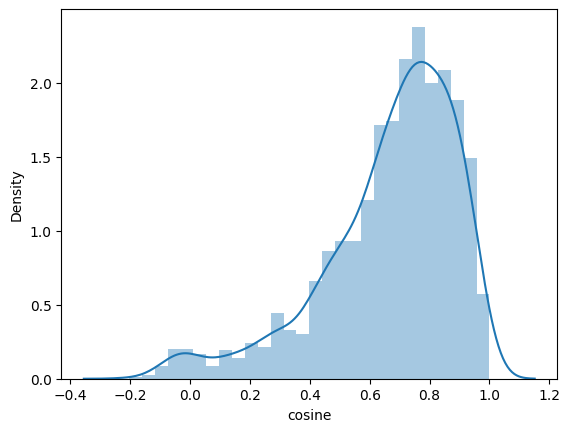

In [17]:
sns.distplot(df_gemini['cosine'])

## LLM-as-a-judge (mod 3.8)

In [24]:
prompt1_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: {answer_original}
Generated Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

prompt2_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

In [20]:
df_sample = df_gemini.sample(n=150, random_state=1)

In [21]:
samples = df_sample.to_dict(orient='records')

In [22]:
record = samples[0]
record

{'answer_llm': 'The syntax for using `precision_recall_fscore_support` in Python is as follows:\n\n```python\nfrom sklearn.metrics import precision_recall_fscore_support\nprecision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)\n```\n',
 'answer_original': 'Scikit-learn offers another way: precision_recall_fscore_support\nExample:\nfrom sklearn.metrics import precision_recall_fscore_support\nprecision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)\n(Gopakumar Gopinathan)',
 'document': '403bbdd8',
 'question': 'What is the syntax for using precision_recall_fscore_support in Python?',
 'course': 'machine-learning-zoomcamp',
 'cosine': 0.901075541973114}

In [25]:
prompt = prompt1_template.format(**record)
print(prompt)

You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: Scikit-learn offers another way: precision_recall_fscore_support
Example:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)
(Gopakumar Gopinathan)
Generated Question: What is the syntax for using precision_recall_fscore_support in Python?
Generated Answer: The syntax for using `precision_recall_fscore_support` in Python is as follows:

```python
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_

In [32]:
import json

In [33]:
answer = llm(prompt)

In [43]:
answer = answer.replace('```json', '', 1).replace('```', '')

In [44]:
json.loads(answer)

{'Relevance': 'RELEVANT',
 'Explanation': 'The generated answer provides the exact syntax as shown in the original answer. The question asked about the syntax, which the generated answer provides correctly and completely.'}

In [45]:
evaluations = []

for record in tqdm(samples):
    prompt = prompt1_template.format(**record)
    evaluation = llm(prompt)
    evaluations.append(evaluation.replace('```json', '', 1).replace('```', ''))

100%|███████████████████████████████████████████████████| 150/150 [02:09<00:00,  1.16it/s]


In [46]:
json_evaluations = []

for i, str_eval in enumerate(evaluations):
    json_eval = json.loads(str_eval)
    json_evaluations.append(json_eval)

In [47]:
df_evaluations = pd.DataFrame(json_evaluations)

In [49]:
df_evaluations.Relevance.value_counts()

Relevance
RELEVANT           121
PARTLY_RELEVANT     16
NON_RELEVANT        13
Name: count, dtype: int64

In [50]:
df_evaluations[df_evaluations.Relevance == 'NON_RELEVANT']

,Relevance,Explanation
4,NON_RELEVANT,The generated answer discusses Scikit-Learn ve...
11,NON_RELEVANT,The generated answer states that there is no i...
27,NON_RELEVANT,The generated answer discusses filtering a dat...
41,NON_RELEVANT,The original answer discusses access to a repo...
44,NON_RELEVANT,The original answer simply refers to a previou...
45,NON_RELEVANT,"The generated answer discusses resolving a ""re..."
67,NON_RELEVANT,"The generated answer is simply ""The answer is ..."
81,NON_RELEVANT,The generated answer states it cannot answer t...
90,NON_RELEVANT,The generated question asks who provided the s...
93,NON_RELEVANT,The generated answer completely misses the poi...


In [52]:
evaluations_2 = []

for record in tqdm(samples):
    prompt = prompt2_template.format(**record)
    evaluation = llm(prompt)
    evaluations_2.append(evaluation.replace('```json', '', 1).replace('```', ''))

100%|███████████████████████████████████████████████████| 150/150 [02:08<00:00,  1.17it/s]


In [53]:
json_evaluations_2 = []

for i, str_eval in enumerate(evaluations_2):
    json_eval = json.loads(str_eval)
    json_evaluations_2.append(json_eval)

JSONDecodeError: Expecting ',' delimiter: line 1 column 160 (char 159)

In [56]:
str_eval

'{"Relevance": "RELEVANT", "Explanation": "The generated answer directly addresses the question by providing a possible cause for the \'Failed to import module "service": No module named \'sklearn\'\' error in Bentoml and a solution. The answer suggests checking the `bentofile.yaml` file for an incorrect package name (\'sklearn\' instead of \'scikit-learn\') and provides instructions on how to correct it."}\n'

In [68]:
a = str_eval.replace('```json', '', 1).replace('```', '').replace("\'", '').replace('""', '\"')
a

'{"Relevance": "RELEVANT", "Explanation": "The generated answer directly addresses the question by providing a possible cause for the Failed to import module "service": No module named sklearn error in Bentoml and a solution. The answer suggests checking the `bentofile.yaml` file for an incorrect package name (sklearn instead of scikit-learn) and provides instructions on how to correct it."}\n'

In [69]:
json.loads(a)

JSONDecodeError: Expecting ',' delimiter: line 1 column 159 (char 158)